In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx

ModuleNotFoundError: No module named 'geopandas'

In [3]:
df = pd.read_csv('data/kc_house_data.csv')

In [4]:
df = df.dropna()

df = df[(df.lat > 47.087) &
        (df.lat < 47.779) &
        (df.long > -122.527) &
        (df.long < -121.064)]

df.reset_index(drop=True, inplace=True)

In [5]:
df_split = df.address.str.replace(',', '').str.split(' ')
df_split

0        [2102, Southeast, 21st, Court, Renton, Washing...
1        [11231, Greenwood, Avenue, North, Seattle, Was...
2        [8504, South, 113th, Street, Seattle, Washingt...
3        [4079, Letitia, Avenue, South, Seattle, Washin...
4        [2193, Northwest, Talus, Drive, Issaquah, Wash...
                               ...                        
29172    [4673, Eastern, Avenue, North, Seattle, Washin...
29173    [4131, 44th, Avenue, Southwest, Seattle, Washi...
29174    [910, Martin, Luther, King, Jr, Way, Seattle, ...
29175    [17127, 114th, Avenue, Southeast, Renton, Wash...
29176    [18615, 7th, Avenue, South, Burien, Washington...
Name: address, Length: 29177, dtype: object

In [6]:
zips = []
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for x in df_split:
    for y in x:
        if (y[0] == '9') & (len(y) == 5):
            zips.append(y)
for x in zips:
    if x[1] != '8':
        zips.remove(x)
df['zip'] = pd.Series(zips)

In [7]:
#Creaet dict of mean prices by zip code
zips_avg_prices = df.groupby(df.zip).mean()['price']
zip_mean_dict = zips_avg_prices.to_dict()

# Map mean proce by zip into new column
df['zip_mean'] = df['zip'].map(zip_mean_dict)
df['zip_mean']

# Create zip price mean category column

price_cat = []

for price in df['zip_mean']:
    if price < 714997.7:
        price_cat.append(1)
    elif price < 1320000:
        price_cat.append(2)
    else:
        price_cat.append(3)
        
df['price_cat'] = price_cat

In [8]:
# Encode ordinals
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

data_categorical = pd.DataFrame(df.select_dtypes("object")).drop(['date','address'], axis=1)
ordinal_data = data_categorical[['view', 'condition', 'grade']]

# Ordinal encode 'view' and create df for concat

view_ord_cats = [['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']]

view_ords = OrdinalEncoder(categories=view_ord_cats)
view_ords.fit(pd.DataFrame(ordinal_data['view']))
view_encoded = view_ords.transform(pd.DataFrame(ordinal_data['view']))
view_encoded

view_enc = pd.DataFrame(view_encoded, columns=['view_enc'])

# Ordinal encode 'condition' and create df for concat

condition_ord_cats = [['Poor', 'Fair', 'Average', 'Good', 'Very Good']]

cond_ords = OrdinalEncoder(categories=condition_ord_cats)
cond_ords.fit(pd.DataFrame(ordinal_data['condition']))
cond_encoded = cond_ords.transform(pd.DataFrame(ordinal_data['condition']))
cond_encoded

cond_enc = pd.DataFrame(cond_encoded, columns=['cond_enc'])
cond_enc

# Ordinal encode 'grade' and create df for concat

grade_ord_cats = [['1', '2 Substandard','3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']]

grade_ords = OrdinalEncoder(categories=grade_ord_cats)
grade_ords.fit(pd.DataFrame(ordinal_data['grade']))
grade_encoded = grade_ords.transform(pd.DataFrame(ordinal_data['grade']))
grade_encoded

grade_enc = pd.DataFrame(grade_encoded, columns=['grade_enc'])

In [9]:
# Create dummy columns of non-ordinal category data

cat_data = pd.DataFrame(df.select_dtypes("object")).drop(['date','address', 'zip'], axis=1)

cat_dums = pd.get_dummies(cat_data)
cat_dums = cat_dums.add_suffix('_dum')

In [10]:
# Concatonate numerical and encoded features

# Concat ordinal dfs
ords_conc = pd.concat([view_enc, cond_enc, grade_enc], axis=1)

# Get numerical data
data_numerical = df._get_numeric_data()
data_numerical

#Concatonate all
concat_all = pd.concat([data_numerical, ords_conc, cat_dums], axis=1)

# Set df to new df (concat_all)
df = concat_all
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,...,heat_source_Electricity/Solar_dum,heat_source_Gas_dum,heat_source_Gas/Solar_dum,heat_source_Oil_dum,heat_source_Oil/Solar_dum,heat_source_Other_dum,sewer_system_PRIVATE_dum,sewer_system_PRIVATE RESTRICTED_dum,sewer_system_PUBLIC_dum,sewer_system_PUBLIC RESTRICTED_dum
0,7399300360,675000.0,4,1.0,1180,7140,1.0,1180,0,0,...,0,1,0,0,0,0,0,0,1,0
1,8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1570,0,...,0,0,0,1,0,0,0,0,1,0
2,1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1580,0,...,0,1,0,0,0,0,0,0,1,0
3,1604601802,775000.0,3,3.0,2160,1400,2.0,1090,1070,200,...,0,1,0,0,0,0,0,0,1,0
4,8562780790,592500.0,2,2.0,1120,758,2.0,1120,550,550,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29172,7834800180,1555000.0,5,2.0,1910,4000,1.5,1600,1130,0,...,0,0,0,1,0,0,0,0,1,0
29173,194000695,1313000.0,3,2.0,2020,5800,2.0,2020,0,0,...,0,1,0,0,0,0,0,0,1,0
29174,7960100080,800000.0,3,2.0,1620,3600,1.0,940,920,240,...,0,1,0,0,0,0,0,0,1,0
29175,2781280080,775000.0,3,2.5,2570,2889,2.0,1830,740,480,...,0,1,0,0,0,0,0,0,1,0


In [11]:
# Create binary for grade above average

gr_above_avg = []
for x in df['grade_enc']:
    if x > 7:
        gr_above_avg.append(1)
    else:
        gr_above_avg.append(0)
        
df['gr_above_avg'] = pd.Series(gr_above_avg)
        
cond_above_avg = []
for x in df['cond_enc']:
    if x > 2:
        cond_above_avg.append(1)
    else:
        cond_above_avg.append(0)

df['cond_above_avg'] = pd.Series(cond_above_avg)
        
view_above_avg = []
for x in df['view_enc']:
    if x > 2:
        view_above_avg.append(1)
    else:
        view_above_avg.append(0)

df['view_above_avg'] = pd.Series(view_above_avg)

In [13]:
df_mod = df.copy()
df_mod['locat'] = list(zip(df_mod.long, df_mod.lat))

In [14]:
import math

def haversineSeattle(coord):
    lon, lat = coord
    lonS, latS = (-122.335167, 47.608013)
    
    R = 6371000  # radius of Earth in meters
    phi = math.radians(lat)
    phi_S = math.radians(latS)
    
    delta_phi = math.radians(latS - lat)
    delta_lambda = math.radians(lonS - lon)
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi) * math.cos(phi_S) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    km = (R * c) / 1000  # output distance in kilometers

    km = round(km, 3)

    return km

In [15]:
distance = []
for x in df_mod.locat:
    distance.append(haversineSeattle(x))
df_mod['dist_Seattle'] = pd.Series(distance)

In [16]:
# Create binary for house features - garage, basement, patio

df_mod['has_garage'] = [1 if x > 0 else 0 for x in df_mod['sqft_garage']]
df_mod['has_basement'] = [1 if x > 0 else 0 for x in df_mod['sqft_basement']]
df_mod['has_patio'] = [1 if x > 0 else 0 for x in df_mod['sqft_patio']]

In [17]:
abs(df_mod.corr()['price']).sort_values(ascending=False)

price                                  1.000000
zip_mean                               0.617517
sqft_living                            0.616651
grade_enc                              0.577930
sqft_above                             0.546014
                                         ...   
grade_2 Substandard_dum                0.004660
sewer_system_PRIVATE RESTRICTED_dum    0.004335
heat_source_Oil/Solar_dum              0.002363
heat_source_Other_dum                  0.001024
sewer_system_PUBLIC RESTRICTED_dum     0.000649
Name: price, Length: 66, dtype: float64

In [18]:
# Remove outliers

# Create function that identifies outliers

def find_outliers_IQR(df_mod):
   q1=df_mod.quantile(0.25)
   q3=df_mod.quantile(0.75)
   IQR=q3-q1
   outliers = df_mod[((df_mod<(q1-1.5*IQR)) | (df_mod>(q3+1.5*IQR)))]
   return outliers

def get_outliers(df_mod):
    outliers = find_outliers_IQR(df_mod)
    print('number of outliers: '+ str(len(outliers)))
    print('max outlier value: '+ str(outliers.max()))
    print('min outlier value: '+ str(outliers.min()))
    return print(outliers)

# Remove rows with outliers from dataframe. Currently min outliers are hard coded below after running get_outliers function

df_less_outs = df_mod[df['price'] < 2309000]
df_less_outs = df_less_outs[df_less_outs['sqft_living'] < 4450]
df_less_outs = df_less_outs[df_less_outs['sqft_above'] < 3950]
df_mod = df_less_outs

In [20]:
y = df_mod.price
X = sm.add_constant(df_mod
                    [[
                        'sqft_living'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                 1.169e+04
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:45:30   Log-Likelihood:            -3.8331e+05
No. Observations:               26951   AIC:                         7.666e+05
Df Residuals:                   26949   BIC:                         7.666e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.095e+05   6235.653     49.641      0.000    2.97e+05    3.22e+05
sqft_living   319.1077      2.951    108.130      0.000     313.323     324.892
==============================================================================
Omnibus:                     1542.044   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1917.749
Skew:                           0.571   Prob(JB):                         0.00
Kurtosis:                       3.635   Cond. No.                     5.95e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
df_mod.drop([
    'id',
    'lat',
    'long',
    'view_enc',
    'cond_enc',
    'grade_enc',
    'waterfront_NO_dum',
    'greenbelt_NO_dum',
    'nuisance_NO_dum',
    'view_AVERAGE_dum',
    'view_EXCELLENT_dum',
    'view_FAIR_dum',
    'view_GOOD_dum',
    'view_NONE_dum',
    'condition_Average_dum',
    'condition_Fair_dum',
    'condition_Good_dum',
    'condition_Poor_dum',
    'condition_Very Good_dum',
    'grade_11 Excellent_dum',
    'grade_10 Very Good_dum',
    'grade_12 Luxury_dum',
    'grade_13 Mansion_dum',
    'grade_2 Substandard_dum',
    'grade_3 Poor_dum',
    'grade_4 Low_dum',
    'grade_5 Fair_dum',
    'grade_6 Low Average_dum',
    'grade_7 Average_dum',
    'grade_8 Good_dum',
    'grade_9 Better_dum',
    'locat'
],axis=1, inplace=True)

In [22]:
list(df_mod.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'zip_mean',
 'price_cat',
 'waterfront_YES_dum',
 'greenbelt_YES_dum',
 'nuisance_YES_dum',
 'heat_source_Electricity_dum',
 'heat_source_Electricity/Solar_dum',
 'heat_source_Gas_dum',
 'heat_source_Gas/Solar_dum',
 'heat_source_Oil_dum',
 'heat_source_Oil/Solar_dum',
 'heat_source_Other_dum',
 'sewer_system_PRIVATE_dum',
 'sewer_system_PRIVATE RESTRICTED_dum',
 'sewer_system_PUBLIC_dum',
 'sewer_system_PUBLIC RESTRICTED_dum',
 'gr_above_avg',
 'cond_above_avg',
 'view_above_avg',
 'dist_Seattle',
 'has_garage',
 'has_basement',
 'has_patio']

In [23]:
1 - .380
2 - .564
3 - .594
4 - .609
cond_above_avg - .616

TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [24]:
y = df_mod.price
X = sm.add_constant(df_mod
                    [[
                        'sqft_living',
                        'price_cat',
                        'dist_Seattle',
                        'gr_above_avg',
                        'cond_above_avg',
                        'waterfront_YES_dum'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     7285.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:45:34   Log-Likelihood:            -3.7518e+05
No. Observations:               26951   AIC:                         7.504e+05
Df Residuals:                   26944   BIC:                         7.504e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2736.8184   7471.777      0.366      0.714   -1.19e+04    1.74e+04
sqft_living          256.9422      2.542    101.072      0.000     251.959     261.925
price_cat            2.66e+05   2575.156    103.284      0.000    2.61e+05    2.71e+05
dist_Seattle       -7333.4093    154.405    -47.495      0.000   -7636.051   -7030.768
gr_above_avg        1.945e+05   5515.392     35.259      0.000    1.84e+05    2.05e+05
cond_above_avg        7.2e+04   3387.043     21.256      0.000    6.54e+04    7.86e+04
waterfront_YES_dum  2.208e+05   1.54e+04     14.357      0.000    1.91e+05    2.51e+05
==============================================================================
Omnibus:                     1767.409   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7016.312
Skew:                           0.217   Prob(JB):                         0.00
Kurtosis:                       5.462   Cond. No.                     1.98e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
df_mod['log_price'] = np.log(df_mod.price)
df_mod['sqrt_dist_Seattle'] = np.sqrt(df_mod.dist_Seattle)
df_mod['log_sqft_living'] = np.log(df_mod.sqft_living)

In [26]:
y = df_mod.price
X = sm.add_constant(df_mod
                    [[
                        'log_sqft_living',
                        'price_cat',
                        'sqrt_dist_Seattle',
                        'gr_above_avg',
                        'cond_above_avg',
                        'waterfront_YES_dum'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     6917.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:47:49   Log-Likelihood:            -3.7561e+05
No. Observations:               26951   AIC:                         7.512e+05
Df Residuals:                   26944   BIC:                         7.513e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -2.75e+06   3.39e+04    -81.065      0.000   -2.82e+06   -2.68e+06
log_sqft_living     4.483e+05   4697.015     95.443      0.000    4.39e+05    4.58e+05
price_cat           2.686e+05   2603.214    103.182      0.000    2.64e+05    2.74e+05
sqrt_dist_Seattle  -6.228e+04   1361.485    -45.747      0.000    -6.5e+04   -5.96e+04
gr_above_avg        2.419e+05   5437.431     44.492      0.000    2.31e+05    2.53e+05
cond_above_avg      7.028e+04   3442.923     20.413      0.000    6.35e+04     7.7e+04
waterfront_YES_dum  2.372e+05   1.56e+04     15.180      0.000    2.07e+05    2.68e+05
==============================================================================
Omnibus:                     2747.120   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14025.152
Skew:                           0.370   Prob(JB):                         0.00
Kurtosis:                       6.456   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

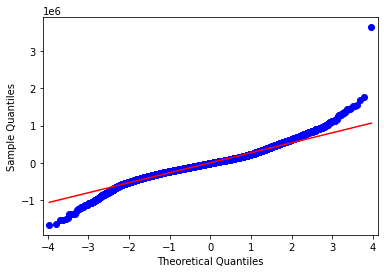

In [27]:
sm.qqplot(model.resid, line='r');

In [28]:
model_preds = model.predict(X)
resids = y - model_preds

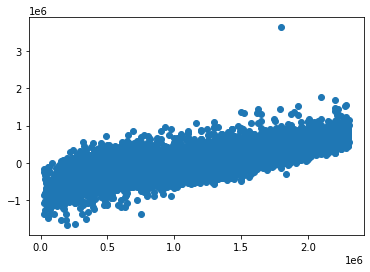

In [29]:
fig, ax = plt.subplots()

ax.scatter(y, resids);
#errors appear to be homoskedastic which is what we want

<AxesSubplot:ylabel='Count'>

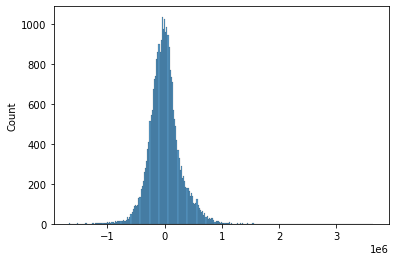

In [30]:
sns.histplot(x=resids)
#residual plot looks to be normally distributed

In [31]:
df_final = df_mod[[
    'log_sqft_living',
    'price_cat',
    'sqrt_dist_Seattle',
    'gr_above_avg',
    'cond_above_avg',
    'waterfront_YES_dum']]

df_final

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=pd.DataFrame()
vif['feature'] = df_final.columns
vif["VIF"] = [variance_inflation_factor(df_final.values, i)
                          for i in range(len(df_final.columns))]

In [32]:
vif.sort_values('VIF',ascending=False)

#Might want to consider dropping a variable. VIF is high for the top 3

,feature,VIF
0,log_sqft_living,29.797414
2,sqrt_dist_Seattle,13.265022
1,price_cat,10.478060
4,cond_above_avg,1.689789
3,gr_above_avg,1.231371
5,waterfront_YES_dum,1.020615
